## Importing libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import talib
from sklearn.neighbors import KNeighborsClassifier

# For portfolio optimisation
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier


## Importing datasets:  

Mini-S&P500 futures

WTI oil futures

Gold futures

<!-- Aluminium futures -->

EUR/USD currency

Wheat futures

<!-- VIX futures -->

Gasoline futures

In [2]:
assets = {
    'Mini-S&P500 Futures': 'ES=F',
    'WTI Oil Futures': 'CL=F',
    'Gold Futures': 'GC=F',
    # 'Aluminium Futures': 'ALI=F',
    'EUR/USD Currency': 'EURUSD=X',
    'Wheat Futures': 'ZW=F',
    # 'VIX Futures': '',
    'Gasoline Futures': 'RB=F'
}

start_date = '2010-01-01'  # First trading day of 2010
end_date = '2023-12-31'    # Last trading day of 2023

futures_data = yf.download(list(assets.values()), start=start_date, end=end_date, auto_adjust=True)

futures_data.index = pd.to_datetime(futures_data.index)
print(futures_data.head())

[*********************100%%**********************]  6 of 6 completed

Price           Close                                                  \
Ticker           CL=F     ES=F  EURUSD=X         GC=F    RB=F    ZW=F   
Date                                                                    
2010-01-01        NaN      NaN  1.438994          NaN     NaN     NaN   
2010-01-04  81.510002  1128.75  1.442398  1117.699951  2.1044  557.75   
2010-01-05  81.769997  1132.25  1.436596  1118.099976  2.1250  553.00   
2010-01-06  83.180000  1133.00  1.440403  1135.900024  2.1366  567.25   
2010-01-07  82.660004  1137.50  1.431803  1133.099976  2.1349  557.75   

Price            High                                  ...      Open  \
Ticker           CL=F     ES=F  EURUSD=X         GC=F  ...  EURUSD=X   
Date                                                   ...             
2010-01-01        NaN      NaN  1.440196          NaN  ...  1.432706   
2010-01-04  81.680000  1129.75  1.445191  1122.300049  ...  1.431004   
2010-01-05  82.000000  1133.00  1.448310  1126.500000  

## Data Cleaning

In [3]:
na_counts = futures_data.isna().sum()
print("NA values per column:")
print(na_counts)

zero_counts = (futures_data == 0).sum()
print("Number of zeros per column:")
print(zero_counts)

NA values per column:
Price   Ticker  
Close   CL=F        130
        ES=F        130
        EURUSD=X      5
        GC=F        131
        RB=F        131
        ZW=F        131
High    CL=F        130
        ES=F        130
        EURUSD=X      5
        GC=F        131
        RB=F        131
        ZW=F        131
Low     CL=F        130
        ES=F        130
        EURUSD=X      5
        GC=F        131
        RB=F        131
        ZW=F        131
Open    CL=F        130
        ES=F        130
        EURUSD=X      5
        GC=F        131
        RB=F        131
        ZW=F        131
Volume  CL=F        130
        ES=F        130
        EURUSD=X      5
        GC=F        131
        RB=F        131
        ZW=F        131
dtype: int64
Number of zeros per column:
Price   Ticker  
Close   CL=F           0
        ES=F           0
        EURUSD=X       0
        GC=F           0
        RB=F           0
        ZW=F           0
High    CL=F           0
        

In [4]:
futures_data = futures_data.dropna()
print("Cleaned Data")
print(futures_data)

cleaned_na_counts = futures_data.isna().sum()
print("TOTAL NA values after cleaning:")
print(cleaned_na_counts.sum())

Cleaned Data
Price           Close                                                  \
Ticker           CL=F     ES=F  EURUSD=X         GC=F    RB=F    ZW=F   
Date                                                                    
2010-01-04  81.510002  1128.75  1.442398  1117.699951  2.1044  557.75   
2010-01-05  81.769997  1132.25  1.436596  1118.099976  2.1250  553.00   
2010-01-06  83.180000  1133.00  1.440403  1135.900024  2.1366  567.25   
2010-01-07  82.660004  1137.50  1.431803  1133.099976  2.1349  557.75   
2010-01-08  82.750000  1141.50  1.441109  1138.199951  2.1553  568.50   
...               ...      ...       ...          ...     ...     ...   
2023-12-22  73.559998  4805.25  1.100619  2057.100098  2.1301  616.25   
2023-12-26  75.570000  4825.00  1.102026  2058.199951  2.1583  636.25   
2023-12-27  74.110001  4833.50  1.104301  2081.899902  2.1550  623.00   
2023-12-28  71.769997  4832.25  1.110864  2073.899902  2.0852  631.50   
2023-12-29  71.650002  4820.00  1.1068

Investigating why ALI=F and VIXY have too many NaN values.

In [5]:
# # Visualize NA occurrences
# futures_data.adj['ALI=F'].isna().astype(int).plot(title='ALI=F NA Occurrences', figsize=(12, 6))
# plt.show()

# futures_data.Close['VIXY'].isna().astype(int).plot(title='VIXY NA Occurrences', figsize=(12, 6))
# plt.show()

# Identify rows with NA values for ALI=F and VIXY
# ali_na_dates = futures_data[futures_data.Close['ALI=F'].isna()].index
# vixy_na_dates = futures_data[futures_data.Close['VIXY'].isna()].index

# print("Dates with NA values for ALI=F:")
# print(ali_na_dates)

# print("Dates with NA values for VIXY:")
# print(vixy_na_dates)

# ali_na_data = futures_data.loc[ali_na_dates, ['Close']]
# vixy_na_data = futures_data.loc[vixy_na_dates, ['Close']]

# print("ALI=F data on dates with NA Close values:")
# # print(ali_na_data.isna().sum())

# print("VIXY data on dates with NA Close values:")
# print(vixy_na_data.isna().sum())

## Split data into training and testing (test data starts from 2020)

In [6]:
# Define the start date for the test set
test_start_date = '2020-01-02'

# Split the data into training and testing sets
train_data = futures_data[futures_data.index < test_start_date]  # Data before 2 Jan 2020
test_data = futures_data[futures_data.index >= test_start_date]  # Data from 2 Jan 2020 onwards

# Check the shapes of the resulting datasets
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

Training data shape: (2507, 30)
Testing data shape: (1006, 30)


Exploratory Data Analysis (To help decide strategies)

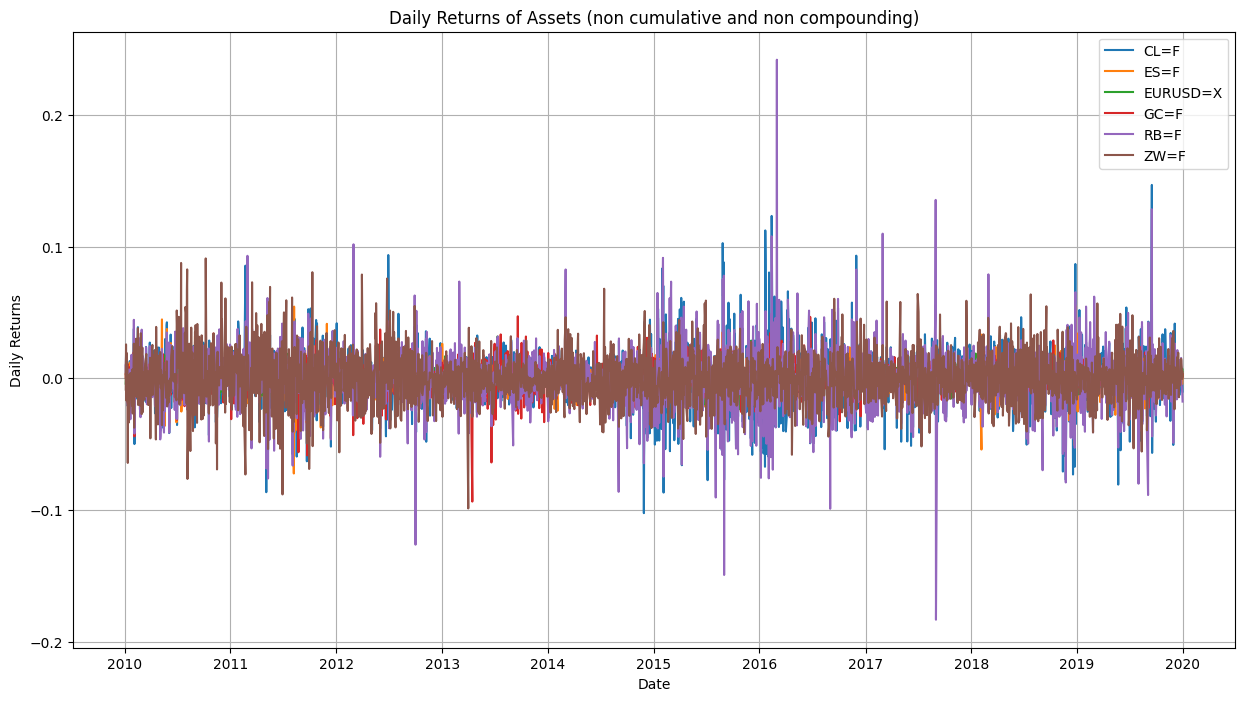

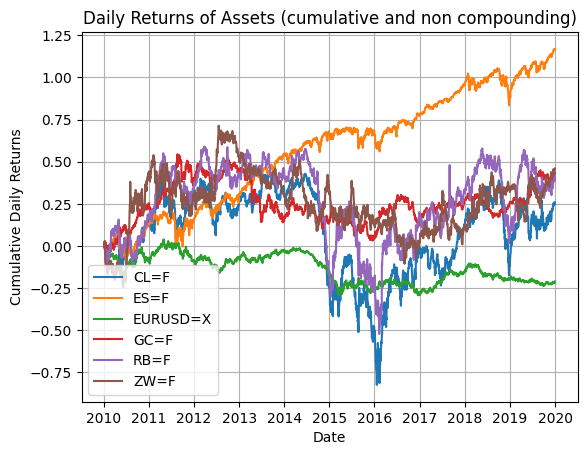

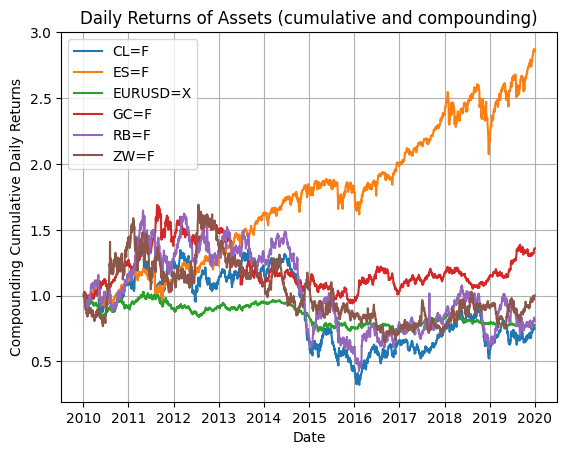

In [7]:
returns_data = train_data['Close'].pct_change().dropna()
# print(returns_data)
cumulative_returns_data = returns_data.cumsum()
compounding_cumulative_returns_data = (1+returns_data).cumprod()


plt.figure(figsize=(15, 8))

# Printing daily returns of the assets (non cumulative and non compounding)
for ticker in returns_data.columns:
    plt.plot(returns_data.index, returns_data[ticker], label=ticker)

plt.title('Daily Returns of Assets (non cumulative and non compounding)')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid(True)
plt.show()

# Printing cumulative daily returns of the assets (non compounding)
for ticker in returns_data.columns:
    plt.plot(cumulative_returns_data.index, cumulative_returns_data[ticker], label=ticker)

plt.title('Daily Returns of Assets (cumulative and non compounding)')
plt.xlabel('Date')
plt.ylabel('Cumulative Daily Returns')
plt.legend()
plt.grid(True)
plt.show()

# Printing compounding cumulative daily returns of the assets
for ticker in returns_data.columns:
    plt.plot(compounding_cumulative_returns_data.index, compounding_cumulative_returns_data[ticker], label=ticker)

plt.title('Daily Returns of Assets (cumulative and compounding)')
plt.xlabel('Date')
plt.ylabel('Compounding Cumulative Daily Returns')
plt.legend()
plt.grid(True)
plt.show()

Setting Benchmark as an equally weighted (across all assets) Buy and Hold strategy. Other Benchmarks? Why did I choose this benchmark?

/var/folders/p6/7w9lzvpn26sfj3ynnhr4xl8h0000gn/T/ipykernel_38564/3255801142.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


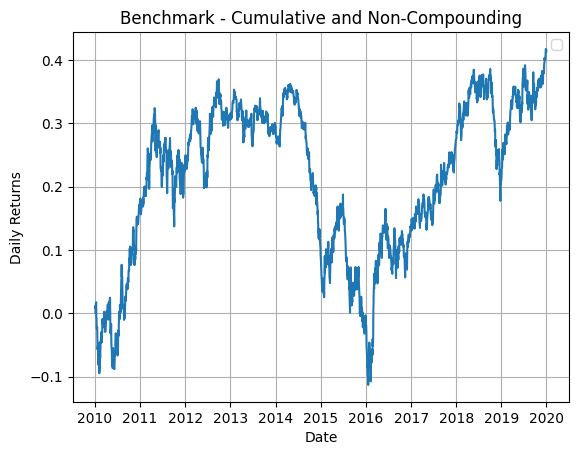

In [8]:
benchmark = returns_data.mean(axis=1)
alternative_benchmark = returns_data['ES=F']
cumulative_benchmark = benchmark.cumsum()
compounding_cumulative_benchmark = (1+benchmark).cumprod()

plt.plot(cumulative_benchmark)

plt.title('Benchmark - Cumulative and Non-Compounding')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid(True)
plt.show()

#### Some other possible options for time series alphas:
1. Check autocorrelation and apply either a trends/mean reversion strategy
2. Cross asset rolling correlation/cointegration (is it time series or cross sectional?)(May be a bad idea since we are dealing with futures and assets are diverse)
3. Pick a random alpha from research paper: https://arxiv.org/ftp/arxiv/papers/1601/1601.00991.pdf, Code:
https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/24_alpha_factor_library/03_101_formulaic_alphas.ipynb

#### EDA for Chart Patterns (time series alpha). Can be ignored.

/var/folders/p6/7w9lzvpn26sfj3ynnhr4xl8h0000gn/T/ipykernel_38564/2952810192.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  mean_ohlcv = train_data.pct_change().groupby(level=0, axis=1).mean()


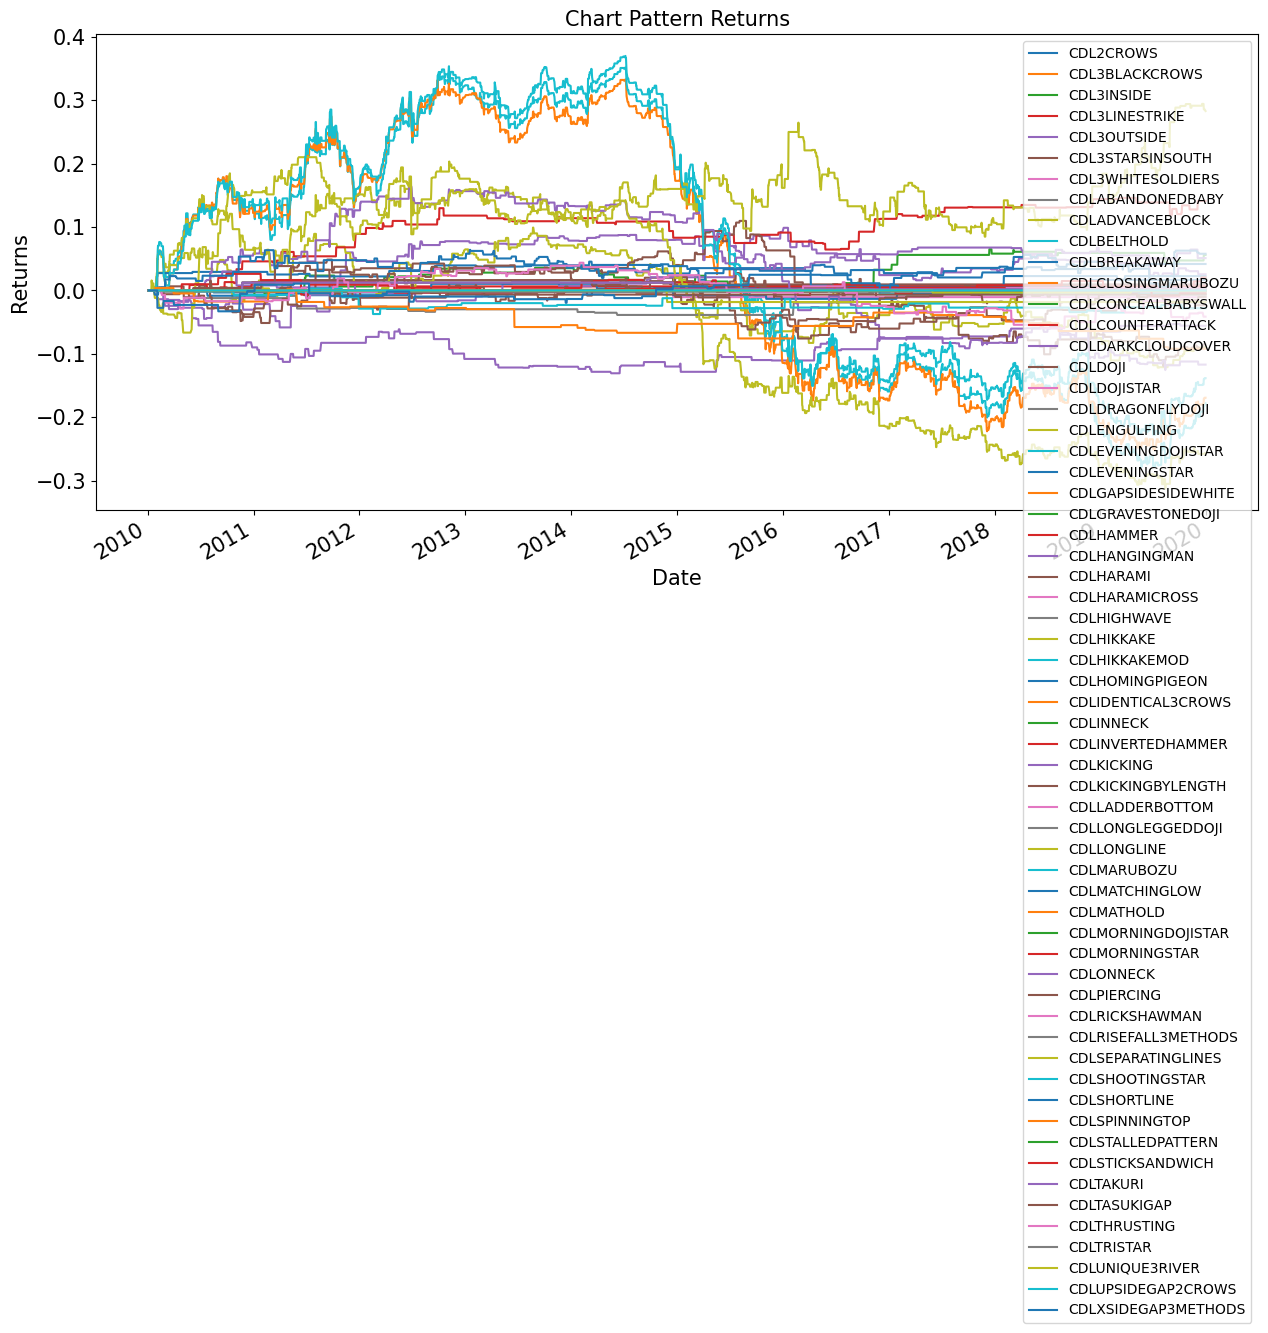

CDLHANGINGMAN    0.051018
CDL3INSIDE       0.055991
CDLSHORTLINE     0.057838
CDLHAMMER        0.141147
CDLHIKKAKE       0.282908
Name: 2019-12-30 00:00:00, dtype: float64

In [9]:
mean_ohlcv = train_data.pct_change().groupby(level=0, axis=1).mean()

signals = {}

# Looping through all TA-Lib functions
for attr in dir(talib):

    # Extraction of chart-pattern functions
    if attr[:3] == 'CDL':

        # Calculation of signals for each chart pattern
        res = getattr(talib, attr)(mean_ohlcv.Open, mean_ohlcv.High, mean_ohlcv.Low, mean_ohlcv.Close)

        # Appending each signal vector to the signals dict
        signals[attr] = res

# Dataframe to store backtest results
backtest_results = pd.DataFrame()

# Looping through the signals for each chart pattern
for pattern in signals:

    # Running the backtest for each chart pattern
    # Signals are -100 and +100, normalise with factor 0.01
    backtest = (0.01*signals[pattern] *
                mean_ohlcv.Close.shift(-1)).cumsum()
    
    backtest_results[pattern] = backtest

    # Plotting the backtest for chart pattern
    ax = backtest.plot(figsize=[15, 7], fontsize=15, legend=False, label=pattern)

    # Set the title and labels
    ax.set_ylabel('Returns', fontdict={'fontsize': 15})
    ax.set_xlabel('Date', fontdict={'fontsize': 15})
    ax.set_title('Chart Pattern Returns', fontdict={'fontsize': 15})
plt.legend()
plt.show()

backtest_results.iloc[-2].sort_values().tail()
# backtest_results.iloc[-2].sort_values().tail()

# CDLLONGLINE          -0.256436
# CDLBELTHOLD          -0.177938
# CDLCLOSINGMARUBOZU   -0.169099
# CDLSHORTLINE     0.057838
# CDLHAMMER        0.141147
# CDLHIKKAKE       0.282908

## Strategy 1: Time-series Micro Alpha
#### Using Chart pattern indicators from TA lib


Testing out different chart pattern indicators and finding the best one. 
Note that some indicators which perform extremely poorly can perform really well when you reverse the indicatorshort for a long signal and 

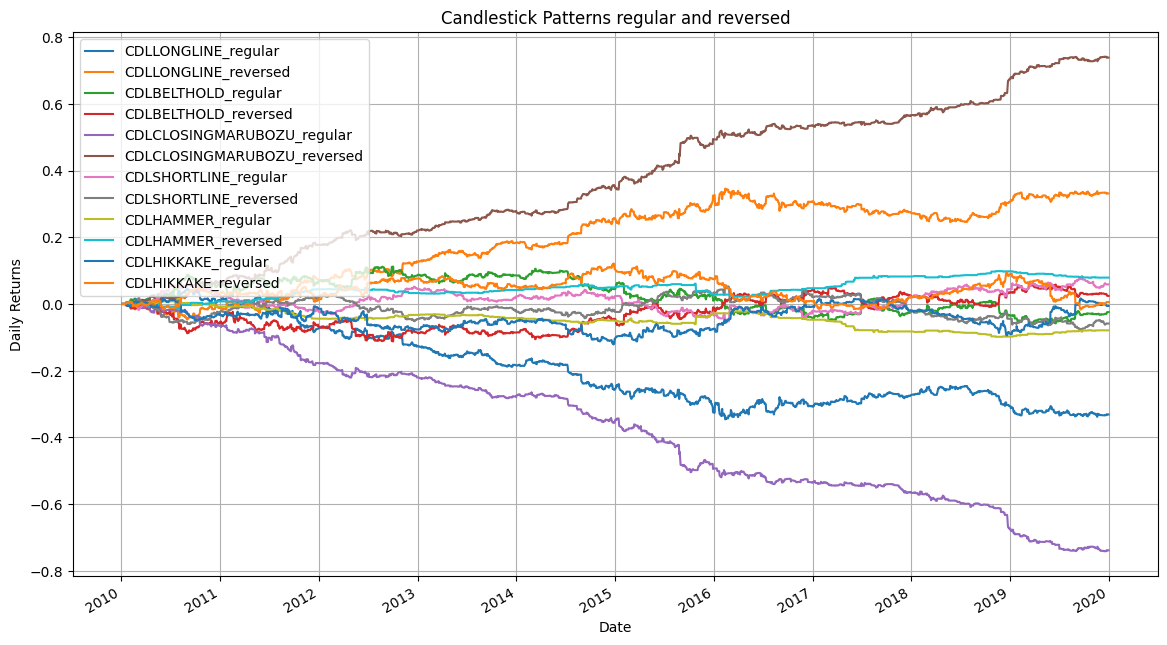

In [10]:
# Candlestick Pattern
# for 
plt.figure(figsize=(14, 8))

candlestick_patterns = ['CDLLONGLINE', 'CDLBELTHOLD', 'CDLCLOSINGMARUBOZU', 'CDLSHORTLINE', 'CDLHAMMER', 'CDLHIKKAKE']

for pattern in candlestick_patterns:
    signal = 0.01*pd.DataFrame({A: getattr(talib, pattern)(
        train_data.Open[A], train_data.High[A], train_data.Low[A], train_data.Close[A]) for A in train_data.Close.columns})
    bt_positive = (signal * train_data.pct_change().Close.shift(-1)).mean(axis=1).fillna(0).cumsum()
    bt_negative = (-signal * train_data.pct_change().Close.shift(-1)).mean(axis=1).fillna(0).cumsum()
    bt_positive.plot(label = pattern + "_regular")
    bt_negative.plot(label = pattern + "_reversed")

plt.title('Candlestick Patterns regular and reversed')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid(True)
plt.show()


# CDLLONGLINE          -0.256436
# CDLBELTHOLD          -0.177938
# CDLCLOSINGMARUBOZU   -0.169099
# CDLSHORTLINE     0.057838
# CDLHAMMER        0.141147
# CDLHIKKAKE       0.282908


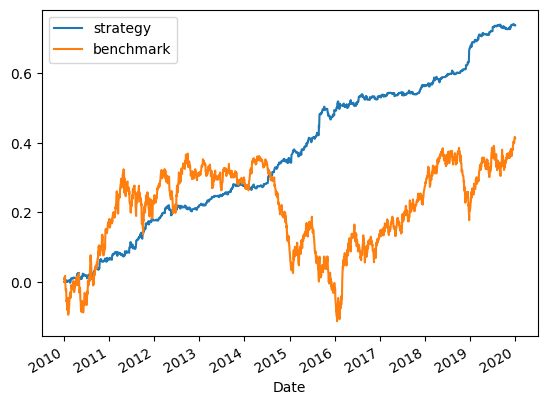

In [11]:
# Chosen patttern = CDLCLOSINGMARUBOZU_reversed as it gives the best returns and very little drawdowns
candlestick_strategy_signals = 0.01*pd.DataFrame({A: talib.CDLCLOSINGMARUBOZU(
        train_data.Open[A], train_data.High[A], train_data.Low[A], train_data.Close[A]) for A in train_data.Close.columns})
candlestick_strategy_backtest = (-candlestick_strategy_signals * train_data.pct_change().Close.shift(-1)).mean(axis=1).fillna(0).cumsum()

candlestick_strategy_backtest.plot(label = "strategy")
cumulative_benchmark.plot(label = "benchmark")
plt.legend()

## Strategy 2: Cross-Sectional Micro Alpha
#### Picking the asset with the highest momentum

Some other options:
1. Volatility based alpha with limits
2. RSI based alpha with threshold

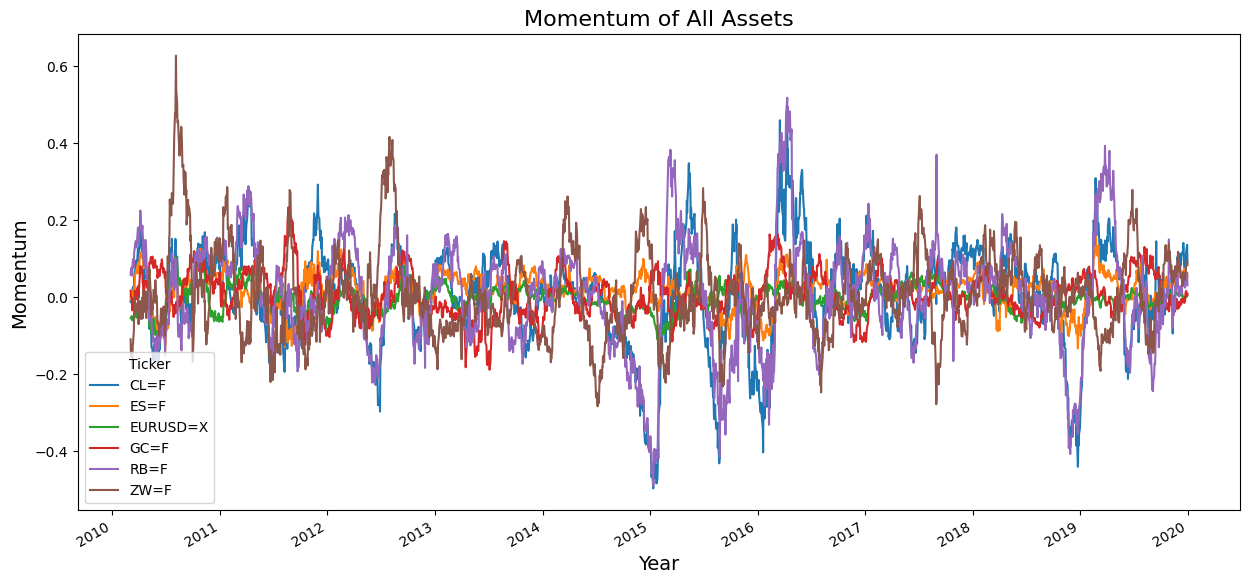

Text(0, 0.5, 'Cumulative Returns')

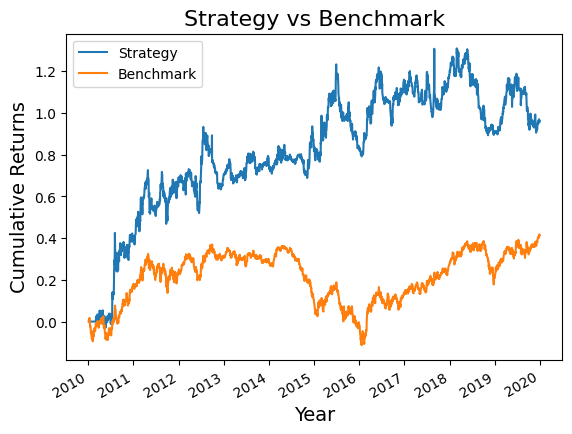

In [12]:
momentum_lookback = 40

# Calculate the momentum of each stock
mom = returns_data.cumsum().apply(lambda x: talib.MOM(x, momentum_lookback))

# Plot momentum of each stock
mom.plot(figsize=(15, 7))

# Set the title and axis labels
plt.title('Momentum of All Assets', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Momentum', fontsize=14)

# Display the chart
plt.show()

# Select the stock with the highest momentum out of the four stocks
selected_rank = len(assets)

mom_signals = (mom.rank(axis=1) == selected_rank)*1
# Run cross-sectional momentum strategy backtest
mom_backtest = ((mom_signals) * returns_data.shift(-1)).sum(axis=1).fillna(0).cumsum()

# Plot backtest and benchmark returns
mom_backtest.plot(label='Strategy')
benchmark.cumsum().plot(label='Benchmark')
plt.legend()

# Set the title and axis labels
plt.title('Strategy vs Benchmark', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)

Strategy 3: Timing Micro Alpha

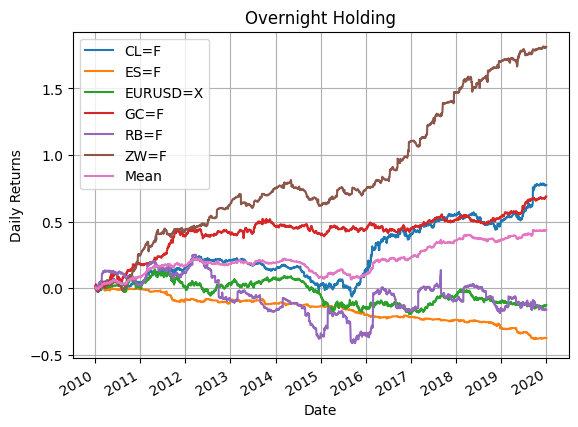

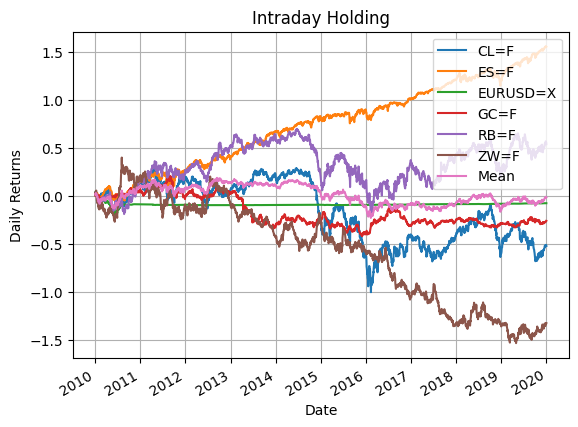

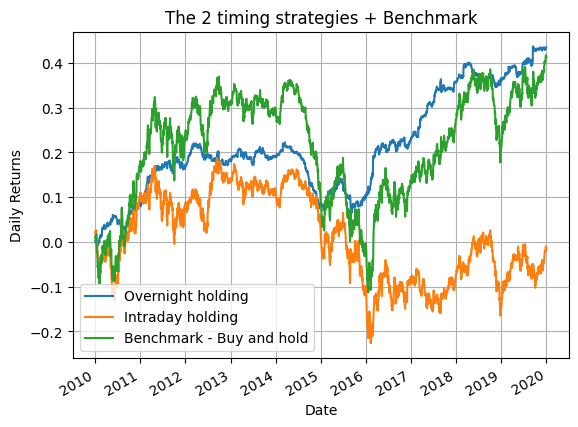

In [13]:
# Timing-1: Overnight holding
overnight_strat = (train_data.Open.shift(-1)/train_data.Close-1).cumsum()
overnight_strat.plot()
overnight_strat.mean(axis=1).plot(label="Mean")
plt.title('Overnight Holding')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid(True)
plt.show()

# Timing-2: Intraday holding
intraday_strat = (train_data.Close/train_data.Open-1).cumsum()
intraday_strat.plot()
intraday_strat.mean(axis=1).plot(label="Mean")
plt.title('Intraday Holding')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid(True)
plt.show()

overnight_strat_backtest = overnight_strat.mean(axis=1)
intraday_strat_backtest = intraday_strat.mean(axis=1)

# Means of the 2 timing strategies compared with the benchmark
overnight_strat_backtest.plot(label="Overnight holding")
intraday_strat_backtest.plot(label="Intraday holding")
cumulative_benchmark.plot(label="Benchmark - Buy and hold")
plt.title('The 2 timing strategies + Benchmark')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid(True)
plt.show()

# Other alternatives include day of the week holding


Overnight holding gives us slightly better performance and has lesser drawdowns than the benchmark. Intraday holding does not give us good performance. So let's choose our timing alpha strategy to be the overnight holding strategy.

Strategy 4: ML Micro Alpha

Putting all strategies together

NA values per column:
timeseries_strategy         0
cross-sectional_strategy    0
timing_strategy             0
dtype: int64
Number of zeros per column:
timeseries_strategy          9
cross-sectional_strategy    40
timing_strategy              0
dtype: int64


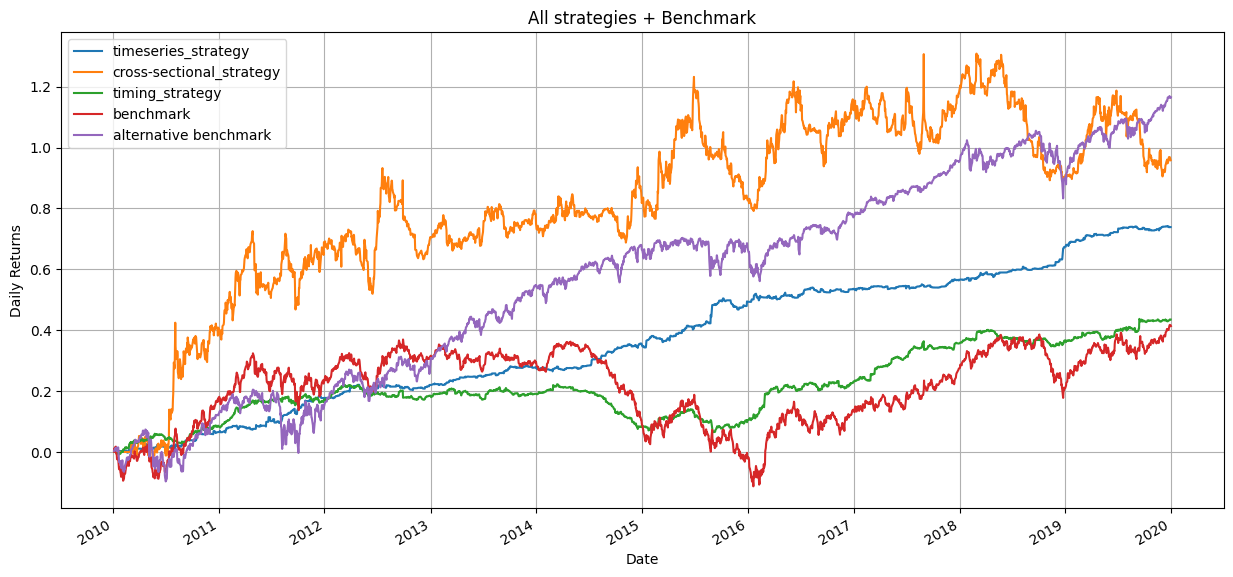

In [14]:
bt = {}
bt['timeseries_strategy'] = candlestick_strategy_backtest
bt['cross-sectional_strategy'] = mom_backtest
bt['timing_strategy'] = overnight_strat_backtest
# bt['machine_learning_strategy'] = 
bt = pd.DataFrame(bt)
# print(bt)

bt = bt.dropna()

na_counts = bt.isna().sum()
print("NA values per column:")
print(na_counts)

zero_counts = (bt == 0).sum()
print("Number of zeros per column:")
print(zero_counts)

bt.plot(figsize=(15, 7))
cumulative_benchmark.plot(label = 'benchmark')
alternative_benchmark.cumsum().plot(label = 'alternative benchmark')
plt.title('All strategies + Benchmark')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid(True)
plt.show()

Combining strategies method 1: Equal weighting of strategies

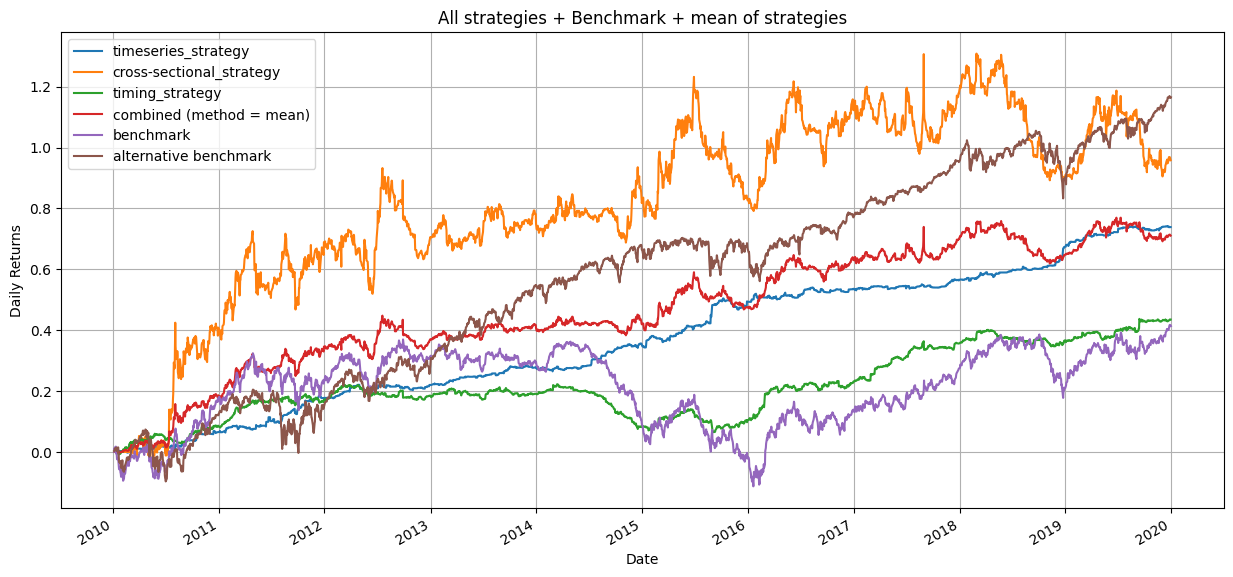

In [15]:
bt.plot(figsize=(15, 7))
bt.mean(axis=1).plot(label='combined (method = mean)')
cumulative_benchmark.plot(label = 'benchmark')
alternative_benchmark.cumsum().plot(label = 'alternative benchmark')

plt.title('All strategies + Benchmark + mean of strategies')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid(True)
plt.show()

Combining strategies method 2: Manual weighting of strategies

Combining strategies method 3: Mean-variance optimised weighting of strategy

In [16]:
# Calculate in-sample PnL array
compounding_bt = (1+bt.diff()).cumprod()

# Calculate average historical returns and covariance matrix
mu = mean_historical_return(compounding_bt)
S = CovarianceShrinkage(compounding_bt).ledoit_wolf()
# print(mu, S)

# Calculating the Efficient Frontier
ef = EfficientFrontier(mu, S)

# Extracting the weights for the max Sharpe (tangent on ef through origin)
weights = ef.max_sharpe()

# Rounding weights
cleaned_weights = ef.clean_weights()
print("Weights for different strategies: ", dict(cleaned_weights))

portf = (bt.diff()*dict(cleaned_weights)).sum(axis=1).cumsum()

Weights for different strategies:  {'timeseries_strategy': 0.77185, 'cross-sectional_strategy': 0.01034, 'timing_strategy': 0.21782}


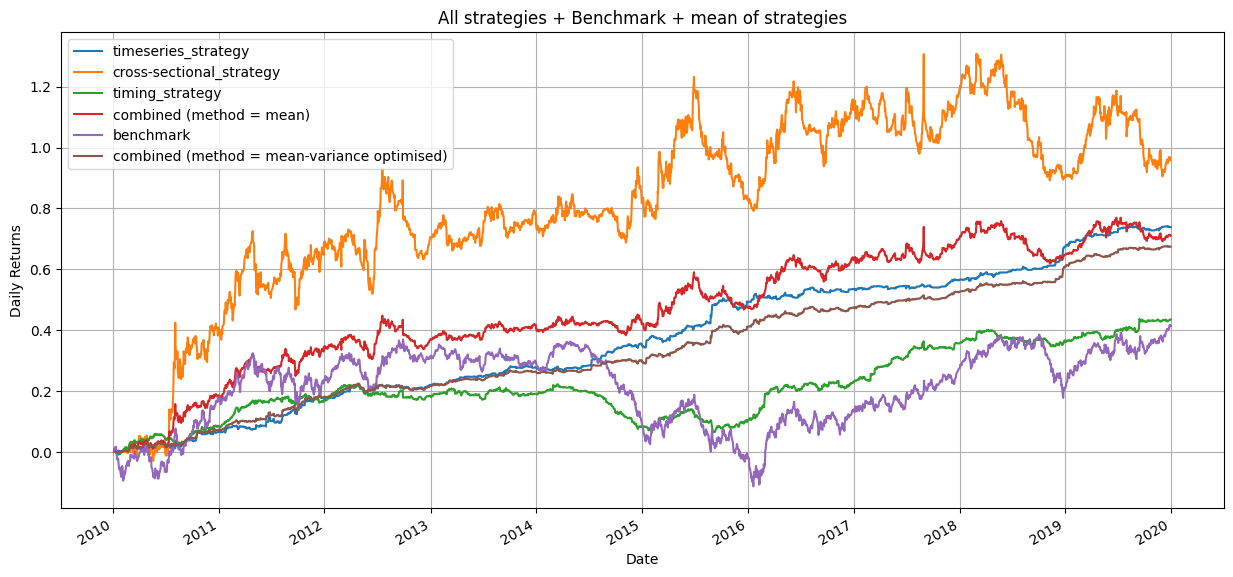

In [17]:
# Plot strategy backtest with optimised weights
bt.plot(figsize=(15, 7))
bt.mean(axis=1).plot(label='combined (method = mean)')
cumulative_benchmark.plot(label = 'benchmark')
# alternative_benchmark.cumsum().plot(label = 'alternative benchmark')
portf.plot(label='combined (method = mean-variance optimised)')
plt.title('All strategies + Benchmark + mean of strategies')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid(True)
plt.show()


Evaluate strategies on training data: CAGR, Sharpe/Sortino Ratio with/without rf rate, Alpha, Beta, Profit factor, Average/Max Drawdown, Profit per trade. Make a dataframe for these metrics, interpret them, make predictions about test data. Compare strategies with the benchmark and against each other.

After you have done your research, will your researched strategies still deliver acceptable performance from 2 Jan 2020 onwards?

Once your simulation is ready, run a study of transaction costs. For simplicity, apply the same level of transaction costs to each contract. And answer the following questions.

What is the highest level of transaction costs your strategy can tolerate?
Could this be improved by reducing the turnover?
How much leverage would you tolerate?

Apply strategies on test data

Evaluate strategies on testing data: CAGR, Sharpe/Sortino Ratio with/without rf rate, Alpha, Beta, Profit factor, Average/Max Drawdown, Profit per trade. Make a dataframe for these metrics, interpret them, make predictions about test data. Compare strategies with the benchmark and against each other.

Does the strategy still hold in the new market regime?
Is it still viable after transaction costs?

Reflect on what you have learned. Write down at least 10 insights from your research.